In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
from scipy.stats import genextreme as gev

# Import some extra functions from utils folder
import sys
sys.path.insert(1, '/home/philinat') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:55:52) 
[GCC 7.5.0]
Virtual memory usage - total: 187 GB / available: 115 GB / percent used: 38.6 %


In [2]:
ds_EOBS = xr.open_dataset('/home/philinat/Stage-M2/rx1day_seas_0.1deg_reg_ens_median_E-OBSv23.1e.nc')
ds_EOBS

<xarray.Dataset>
Dimensions:       (longitude: 705, latitude: 465, time: 285, x: 2)
Coordinates:
  * longitude     (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * latitude      (latitude) float64 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * time          (time) datetime64[ns] 1950-01-14T12:00:00 ... 2021-01-14T12...
Dimensions without coordinates: x
Data variables:
    time_bnds     (time, x) float64 ...
    rx1dayETCCDI  (time, latitude, longitude) float32 ...
Attributes: (12/15)
    CDI:                          Climate Data Interface version 1.6.3 (http:...
    history:                      Mon May 03 15:43:05 2021: cdo -O enspctl,50...
    Conventions:                  CF-1.4
    NCO:                          netCDF Operators version 4.7.5 (Homepage = ...
    nco_openmp_thread_number:     1
    title:                        climate impact indices computed using E-OBS
    ...                           ...
    index_calculation_frequency:  seas
    institute:                    KNMI
    contact:                      eca@knmi.nl
    file_created:                 2021-04-07T09:18:47Z
    climind_version:              1.0.0
    CDO:                          Climate Data Operators version 1.6.3 (http:...

In [8]:
lon_EOBS,lat_EOBS = np.meshgrid(ds_EOBS.longitude,ds_EOBS.latitude)
# les_season_mean0 = np.load('/home/philinat/Stage-M2/saved_data_E-OBS/les_season_mean0.npy')
les_season_max0 = np.reshape(ds_EOBS.rx1dayETCCDI.data[:-1],(71,4,465,705))
print(np.shape(lon_EOBS))
print(np.shape(les_season_max0))

(465, 705)
(71, 4, 465, 705)


(<matplotlib.lines.Line2D at 0x7fa8a9793460>,)

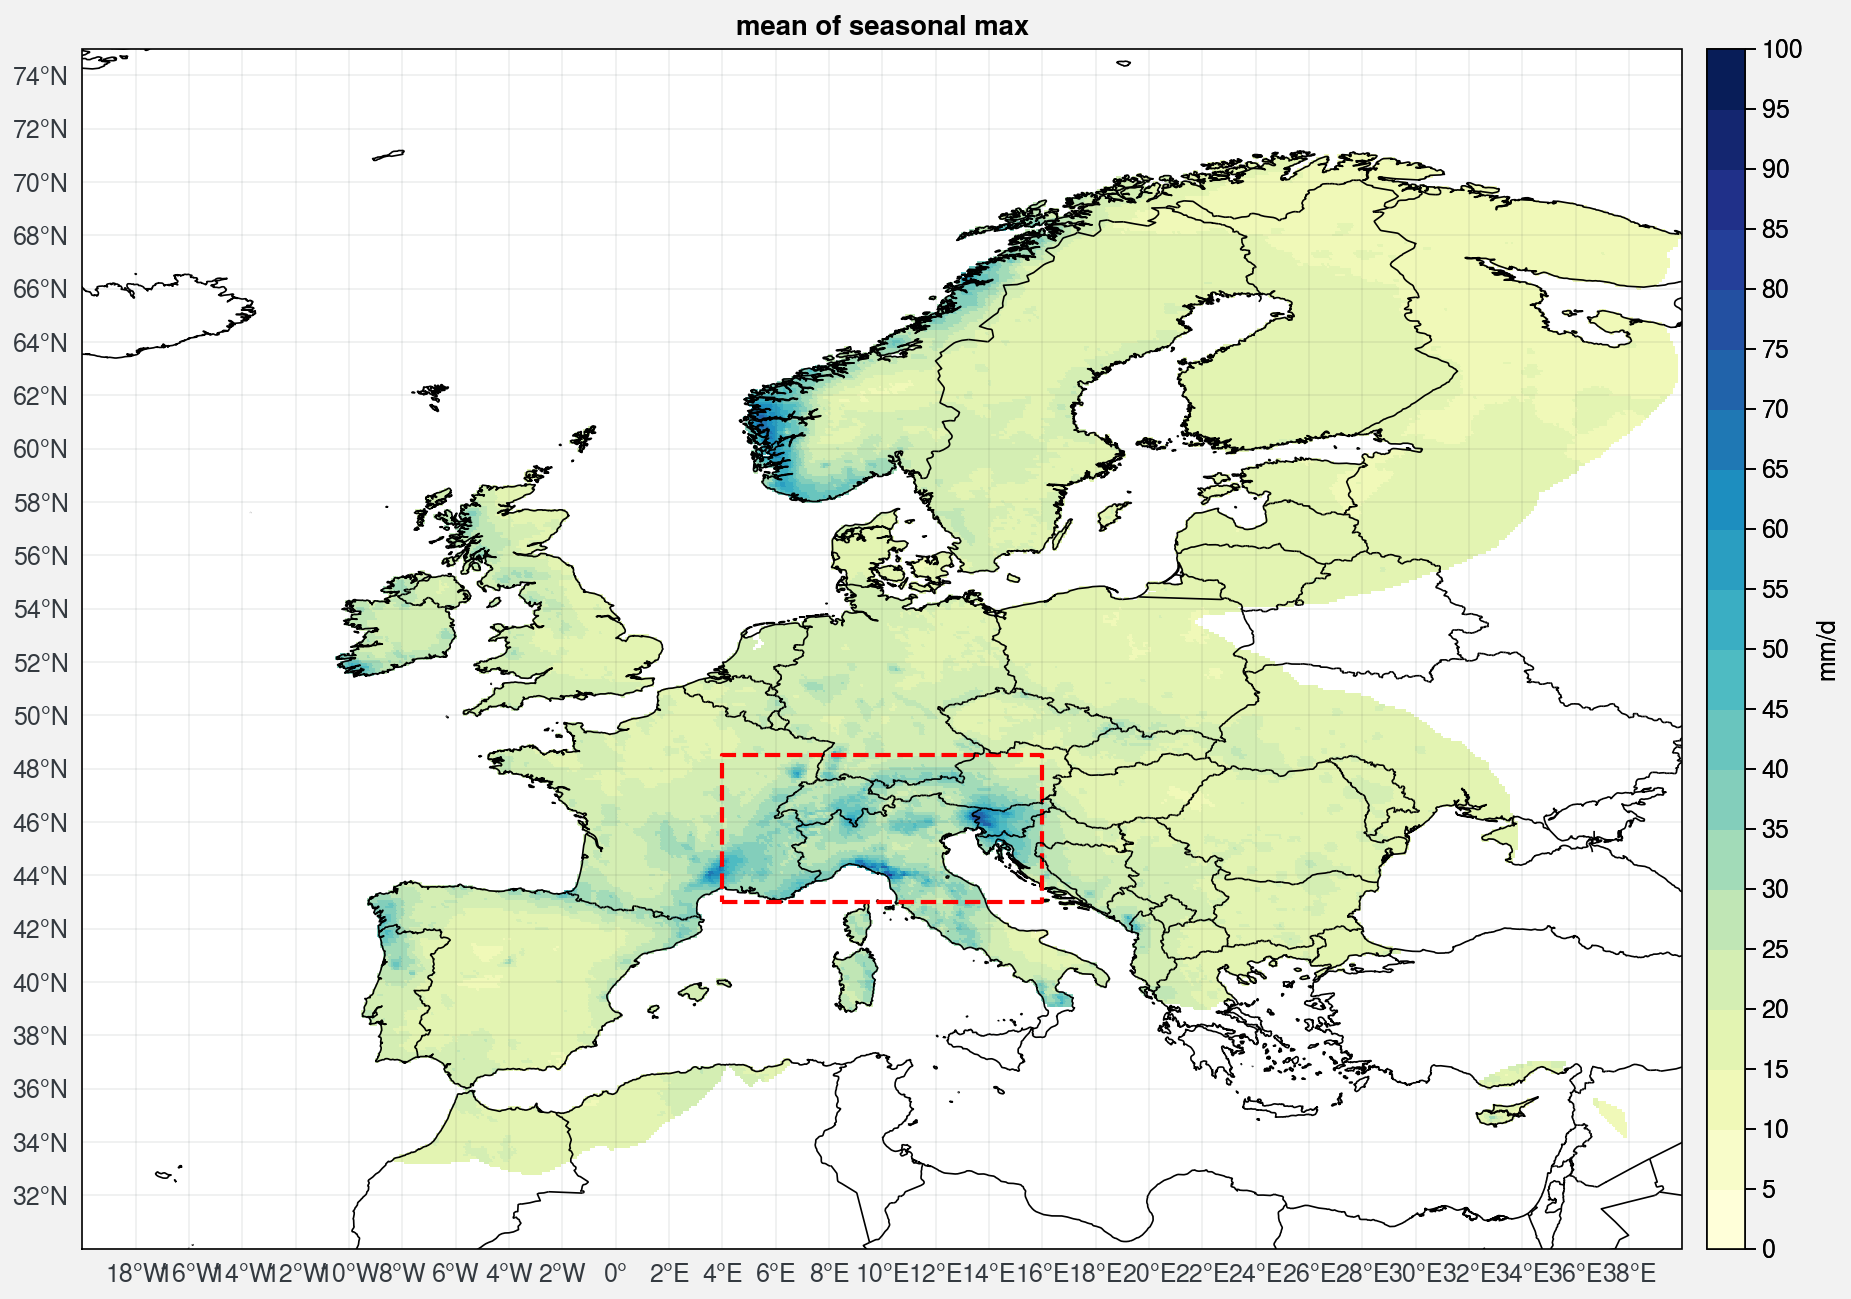

In [21]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(lon_EOBS, lat_EOBS, np.mean(les_season_max0[:,:,:,:],axis=(0,1)),levels=np.linspace(0,100,21),cmap='YlGnBu')
f.colorbar(m,label= 'mm/d')
ax.format(**normal_format,suptitle='mean of seasonal max')
ax.format(latlim=[30.,75.],lonlim=[-20.,40.])
ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

In [10]:


ds_in = xr.Dataset(
    data_vars=dict(p_max=(["time","season","y","x"], les_season_max0)),
    coords=dict(lon=(["y","x"], lon_EOBS),
                lat=([ "y","x"], lat_EOBS),
                season=np.arange(4),
                time=np.arange(1950,2021,1)))

ds_MAR = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')

ds_out = xr.Dataset(
    coords=dict(lon=(["y","x"], ds_MAR.LON.data),
                lat=([ "y","x"], ds_MAR.LAT.data),
                season=np.arange(4),
                time=np.arange(1950,2021,1)))

regridder = xe.Regridder(ds_in, ds_out, 'bilinear')
ds_out = regridder(ds_in)

Create weight file: bilinear_465x705_126x201.nc
using dimensions ('y', 'x') from data variable p_max as the horizontal dimensions for this dataset.


/home/philinat/miniconda3/envs/erca/lib/python3.8/site-packages/xesmf/frontend.py:477: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [11]:
ds_out

<xarray.Dataset>
Dimensions:  (time: 71, season: 4, y: 126, x: 201)
Coordinates:
  * season   (season) int64 0 1 2 3
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2016 2017 2018 2019 2020
    lon      (y, x) float32 1.386 1.47 1.554 1.638 ... 19.51 19.6 19.7 19.79
    lat      (y, x) float32 41.68 41.68 41.69 41.69 ... 49.06 49.05 49.04 49.03
Dimensions without coordinates: y, x
Data variables:
    p_max    (time, season, y, x) float64 3.832 2.096 0.09592 ... 32.75 32.38
Attributes:
    regrid_method:  bilinear

In [12]:
# les_season_mean = ds_out.p_mean.data
les_season_max = ds_out.p_max.data
# np.save('/home/philinat/Stage-M2/saved_data_EOBS/les_season_mean.npy', les_season_mean)
np.save('/home/philinat/Stage-M2/saved_data_EOBS/les_season_max.npy', les_season_max)

(<matplotlib.lines.Line2D at 0x7fa886571b20>,)

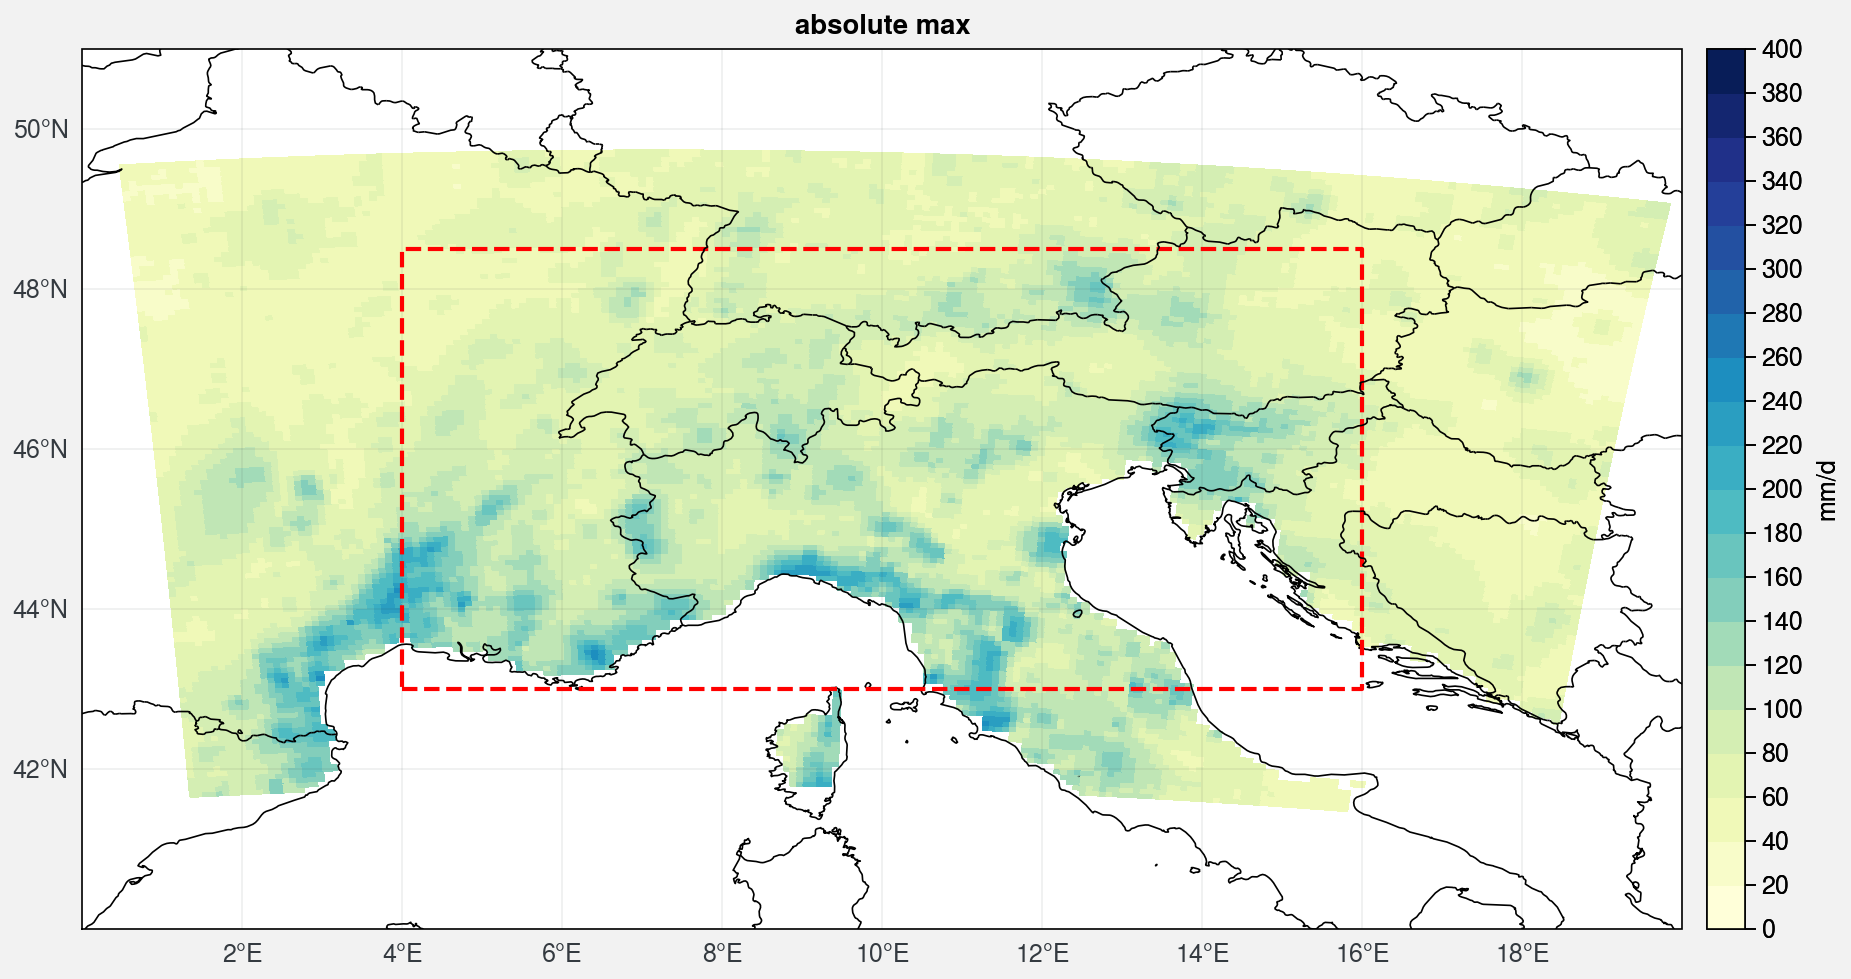

In [15]:
# les_season_mean = np.load('/home/philinat/Stage-M2/saved_data_EOBS/les_season_mean.npy')
# f, ax = pplt.subplots(proj='cyl', axwidth=8)
# m=ax.pcolormesh(ds_out.lon, ds_out.lat, np.mean(les_season_mean[:,:,:,:],axis=(0,1)),levels=np.linspace(0,10,21),cmap='YlGnBu')
# f.colorbar(m,label= 'mm/d')
# ax.format(**normal_format,suptitle='annual mean')
# ax.format(latlim=[40.,51.],lonlim=[0.,20.])
# ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

les_season_max = np.load('/home/philinat/Stage-M2/saved_data_EOBS/les_season_max.npy')

f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(ds_out.lon, ds_out.lat, np.max(les_season_max[:,:,:,:],axis=(0,1)),levels=np.linspace(0,400,21),cmap='YlGnBu')
f.colorbar(m,label= 'mm/d')
ax.format(**normal_format,suptitle='absolute max')
ax.format(latlim=[40.,51.],lonlim=[0.,20.])
ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

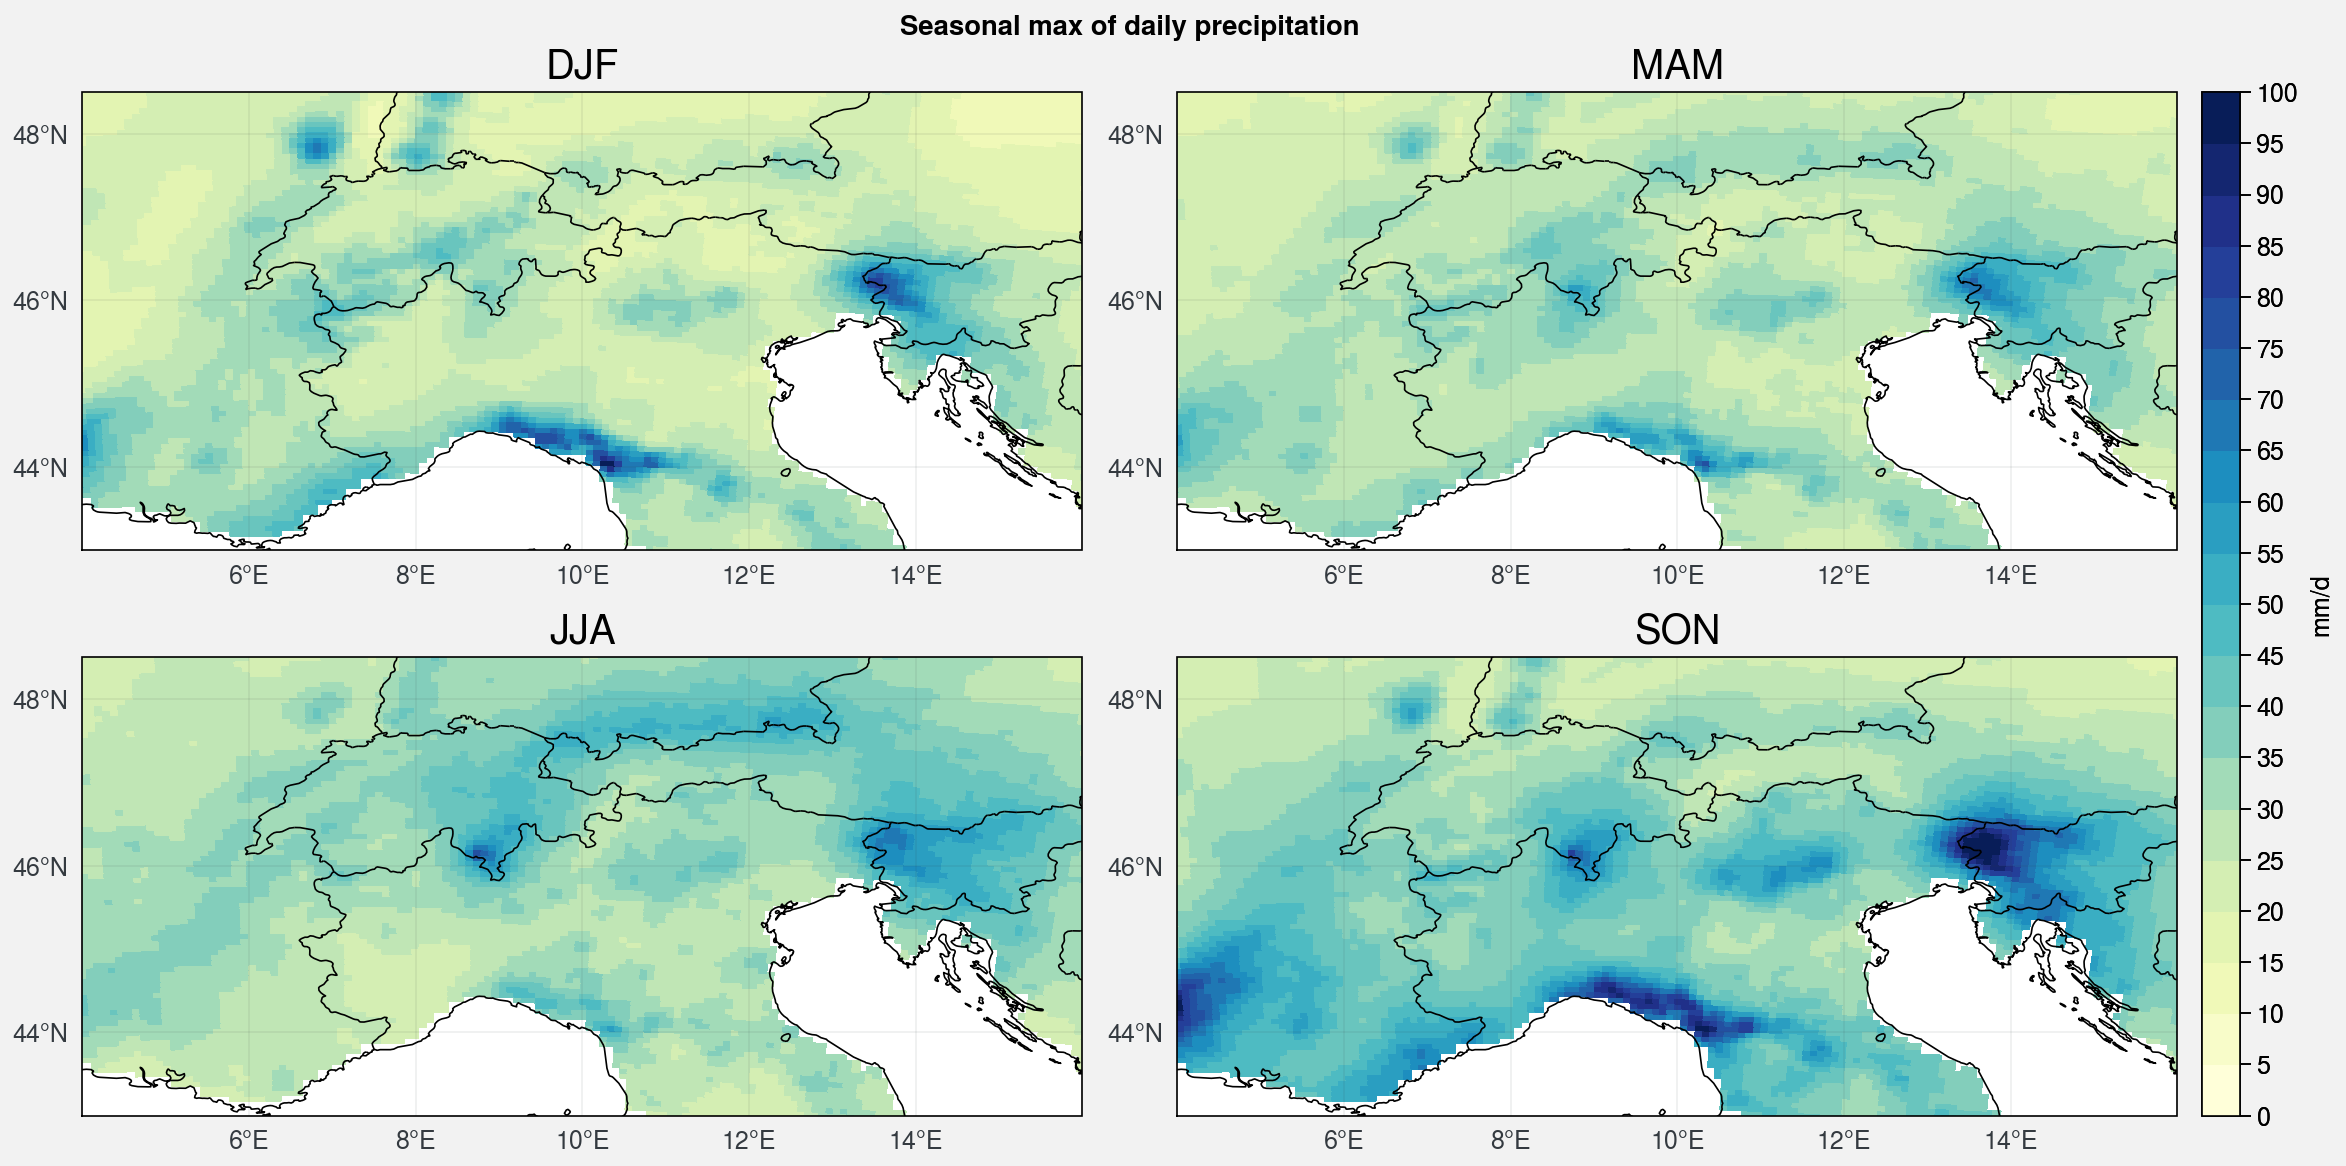

In [18]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
les_season_max = np.load('/home/philinat/Stage-M2/saved_data_EOBS/les_season_max.npy')
seasonal_max = np.mean(les_season_max,axis=0)
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_max[i,:,:],levels=np.linspace(0,100,21),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Seasonal max of daily precipitation")


In [9]:
ds_EOBS = xr.open_dataset('/home/philinat/Stage-M2/txx_seas_0.1deg_reg_ens_median_E-OBSv23.1e.nc')
ds_EOBS

<xarray.Dataset>
Dimensions:    (longitude: 705, latitude: 465, time: 285, x: 2)
Coordinates:
  * longitude  (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * latitude   (latitude) float64 25.05 25.15 25.25 25.35 ... 71.25 71.35 71.45
  * time       (time) datetime64[ns] 1950-01-14T12:00:00 ... 2021-01-14T12:00:00
Dimensions without coordinates: x
Data variables:
    time_bnds  (time, x) float64 ...
    txxETCCDI  (time, latitude, longitude) float32 ...
Attributes: (12/15)
    CDI:                          Climate Data Interface version 1.6.3 (http:...
    history:                      Wed Jul 28 16:02:50 2021: cdo -O enspctl,50...
    Conventions:                  CF-1.4
    NCO:                          netCDF Operators version 4.7.5 (Homepage = ...
    nco_openmp_thread_number:     1
    title:                        climate impact indices computed using E-OBS
    ...                           ...
    index_calculation_frequency:  seas
    institute:                    KNMI
    contact:                      eca@knmi.nl
    file_created:                 2021-05-06T10:08:49Z
    climind_version:              1.0.0
    CDO:                          Climate Data Operators version 1.6.3 (http:...

In [10]:
lon_EOBS,lat_EOBS = np.meshgrid(ds_EOBS.longitude,ds_EOBS.latitude)
les_season_max0 = np.reshape(ds_EOBS.txxETCCDI.data[:-1],(71,4,465,705))
print(np.shape(lon_EOBS))
print(np.shape(les_season_max0))

(465, 705)
(71, 4, 465, 705)


(<matplotlib.lines.Line2D at 0x7f5af63466d0>,)

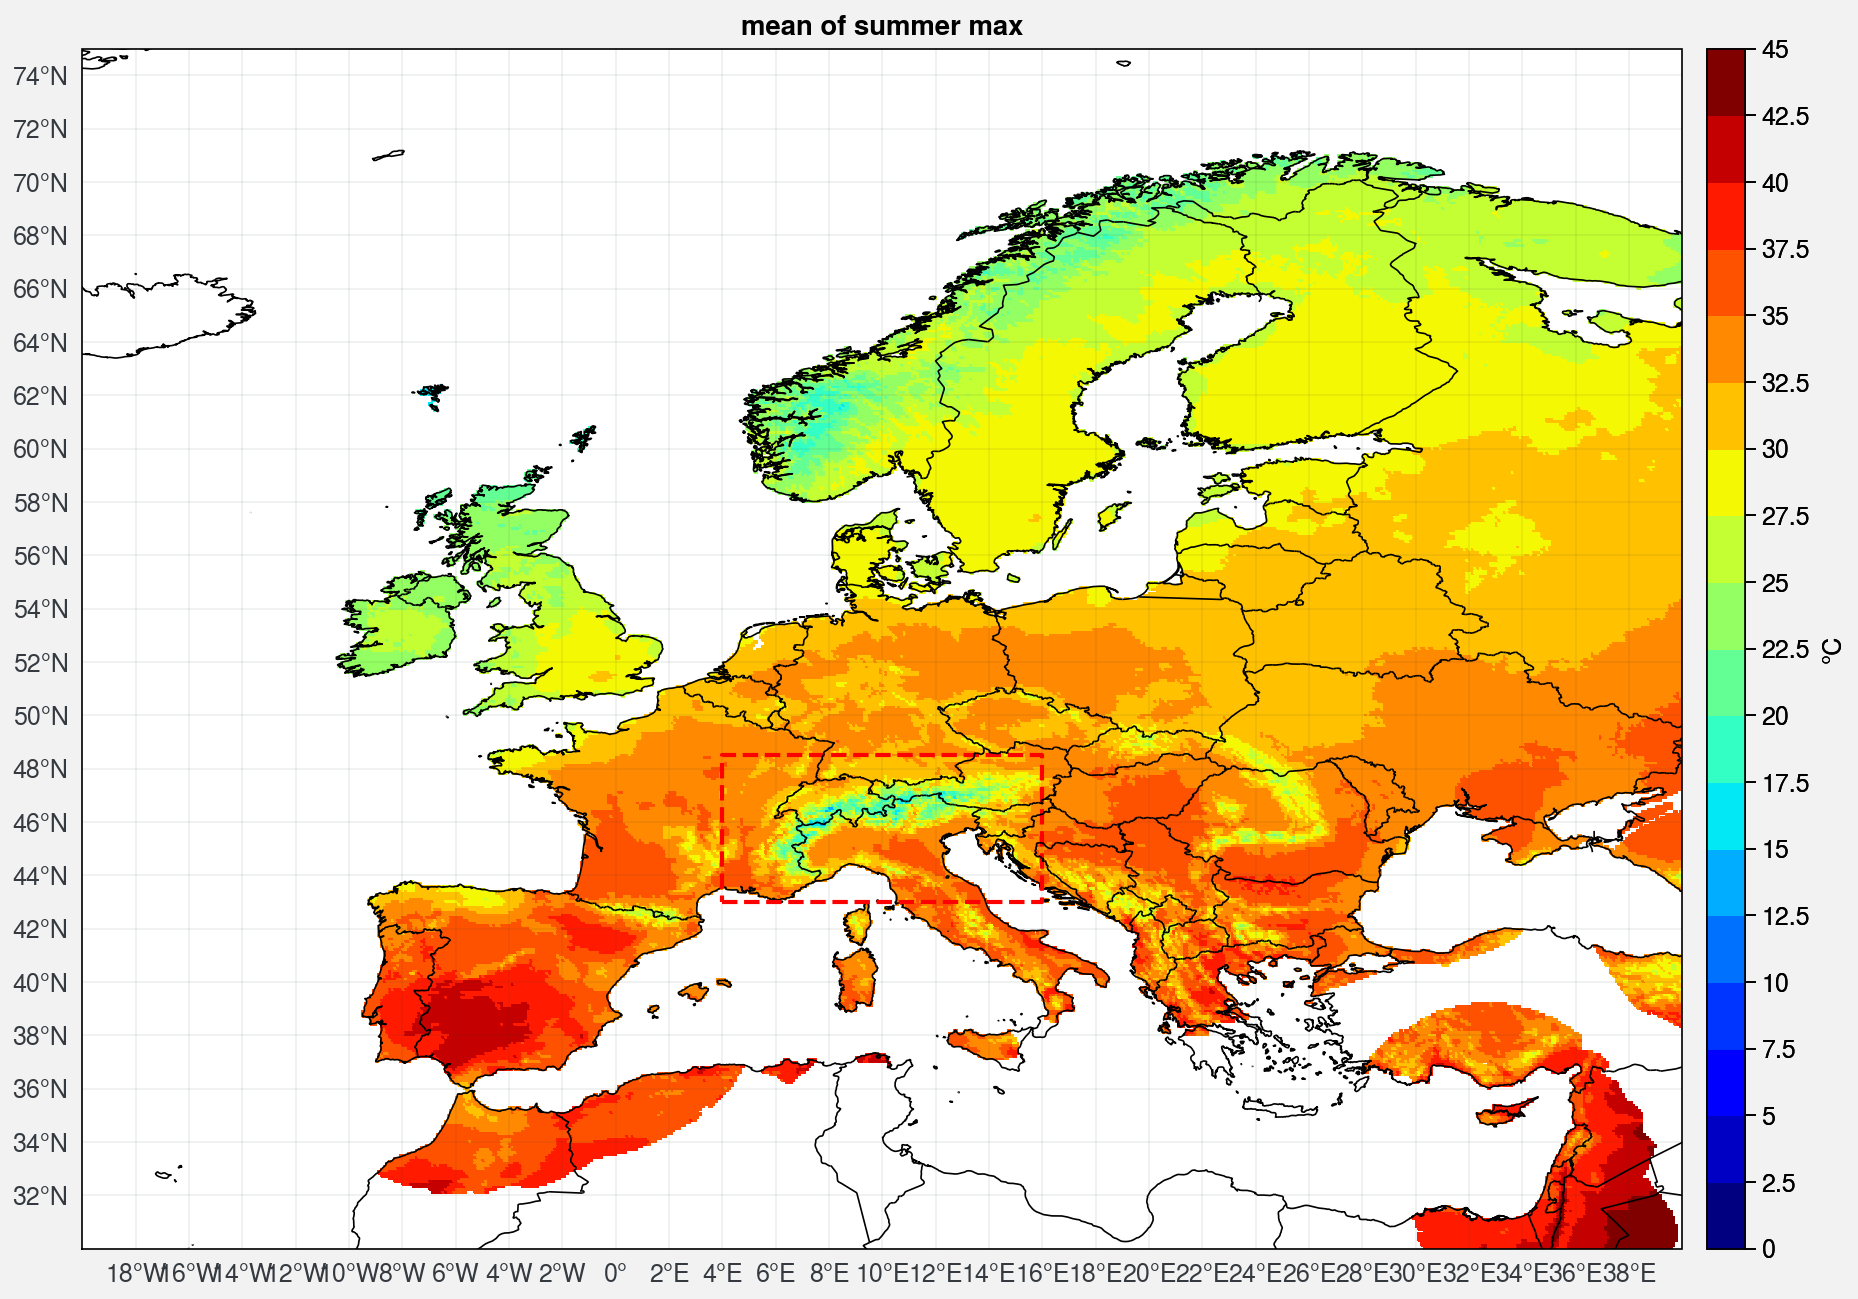

In [18]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(lon_EOBS, lat_EOBS, np.mean(les_season_max0[:,2,:,:],axis=0),levels=np.linspace(0,45,19),cmap='jet')
f.colorbar(m,label= '°C')
ax.format(**normal_format,suptitle='mean of summer max')
ax.format(latlim=[30.,75.],lonlim=[-20.,40.])
ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

In [16]:


ds_in = xr.Dataset(
    data_vars=dict(p_max=(["time","season","y","x"], les_season_max0)),
    coords=dict(lon=(["y","x"], lon_EOBS),
                lat=([ "y","x"], lat_EOBS),
                season=np.arange(4),
                time=np.arange(1950,2021,1)))

ds_MAR = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')

ds_out = xr.Dataset(
    coords=dict(lon=(["y","x"], ds_MAR.LON.data),
                lat=([ "y","x"], ds_MAR.LAT.data),
                season=np.arange(4),
                time=np.arange(1950,2021,1)))

regridder = xe.Regridder(ds_in, ds_out, 'bilinear')
ds_out = regridder(ds_in)

Overwrite existing file: bilinear_465x705_126x201.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('y', 'x') from data variable p_max as the horizontal dimensions for this dataset.


/home/philinat/miniconda3/envs/erca/lib/python3.8/site-packages/xesmf/frontend.py:477: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [17]:
# les_season_mean = ds_out.p_mean.data
les_season_max = ds_out.p_max.data
# np.save('/home/philinat/Stage-M2/saved_data_EOBS/les_season_mean.npy', les_season_mean)
np.save('/home/philinat/Stage-M2/saved_data_EOBS/les_season_maxT.npy', les_season_max)

(<matplotlib.lines.Line2D at 0x7f5af5f3daf0>,)

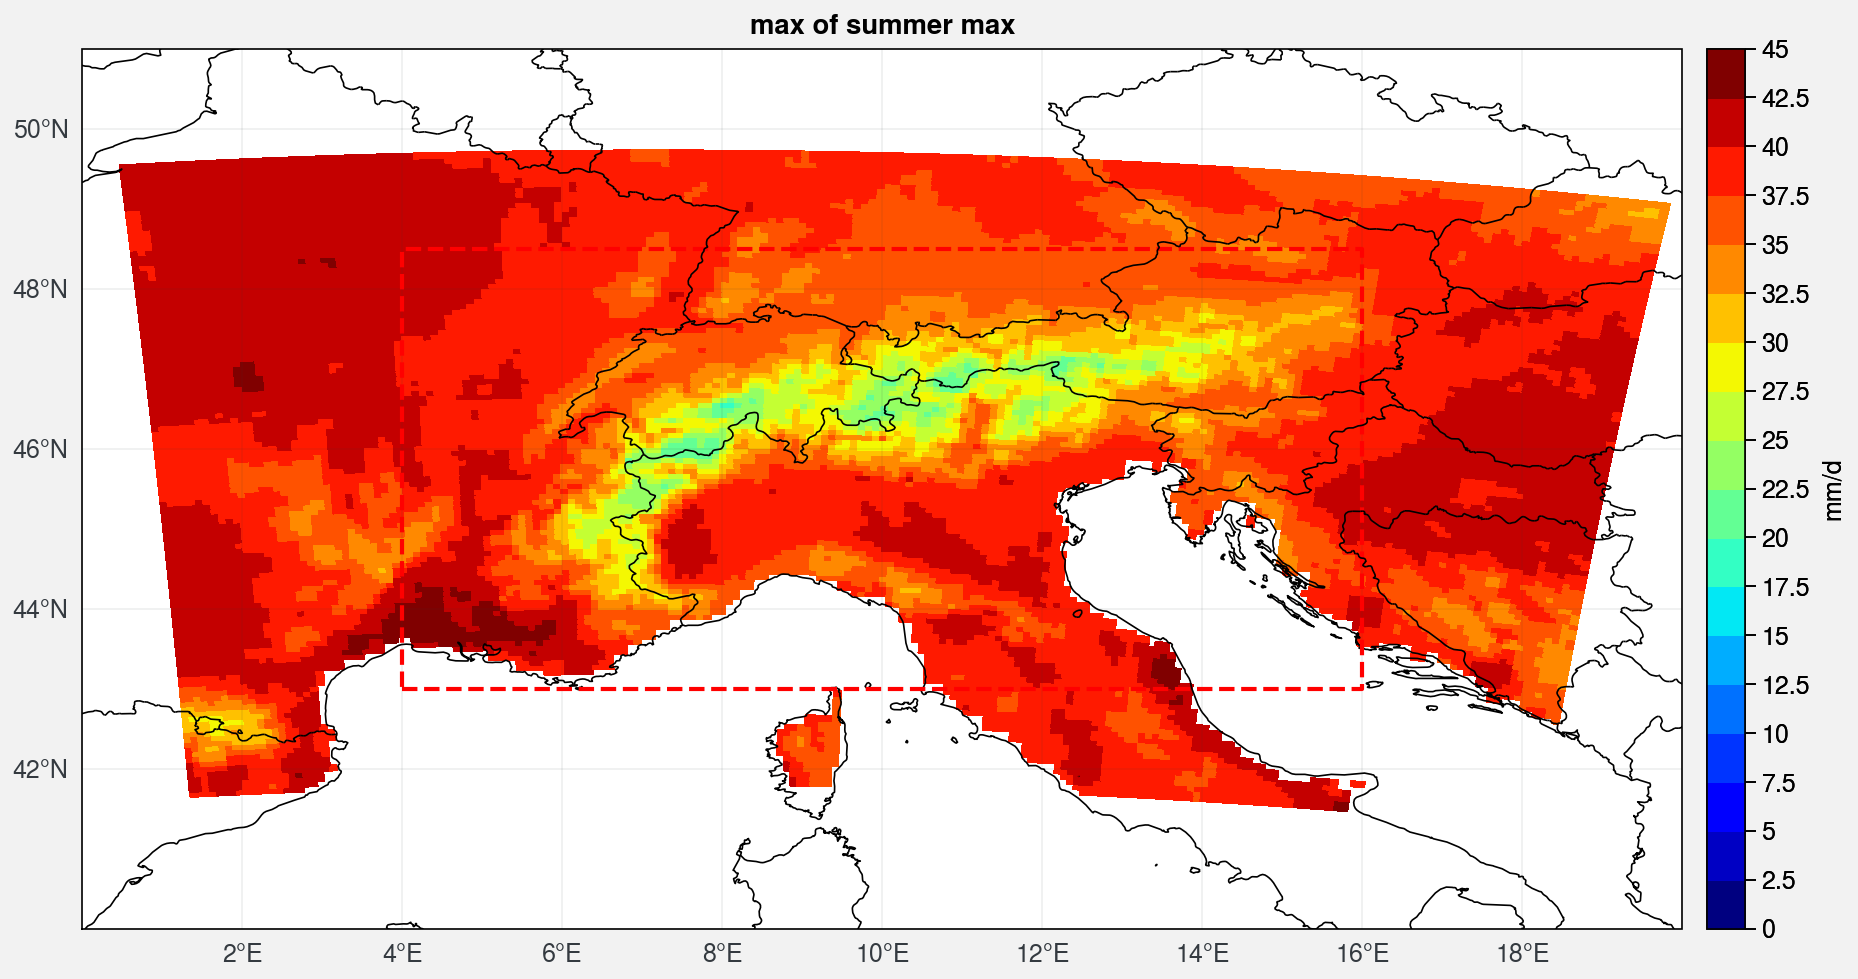

In [21]:
les_season_max = np.load('/home/philinat/Stage-M2/saved_data_EOBS/les_season_maxT.npy')

f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(ds_out.lon, ds_out.lat, np.max(les_season_max[:,2,:,:],axis=0),levels=np.linspace(0,45,19),cmap='jet')
f.colorbar(m,label= '°C')
ax.format(**normal_format,suptitle='max of summer max')
ax.format(latlim=[40.,51.],lonlim=[0.,20.])
ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

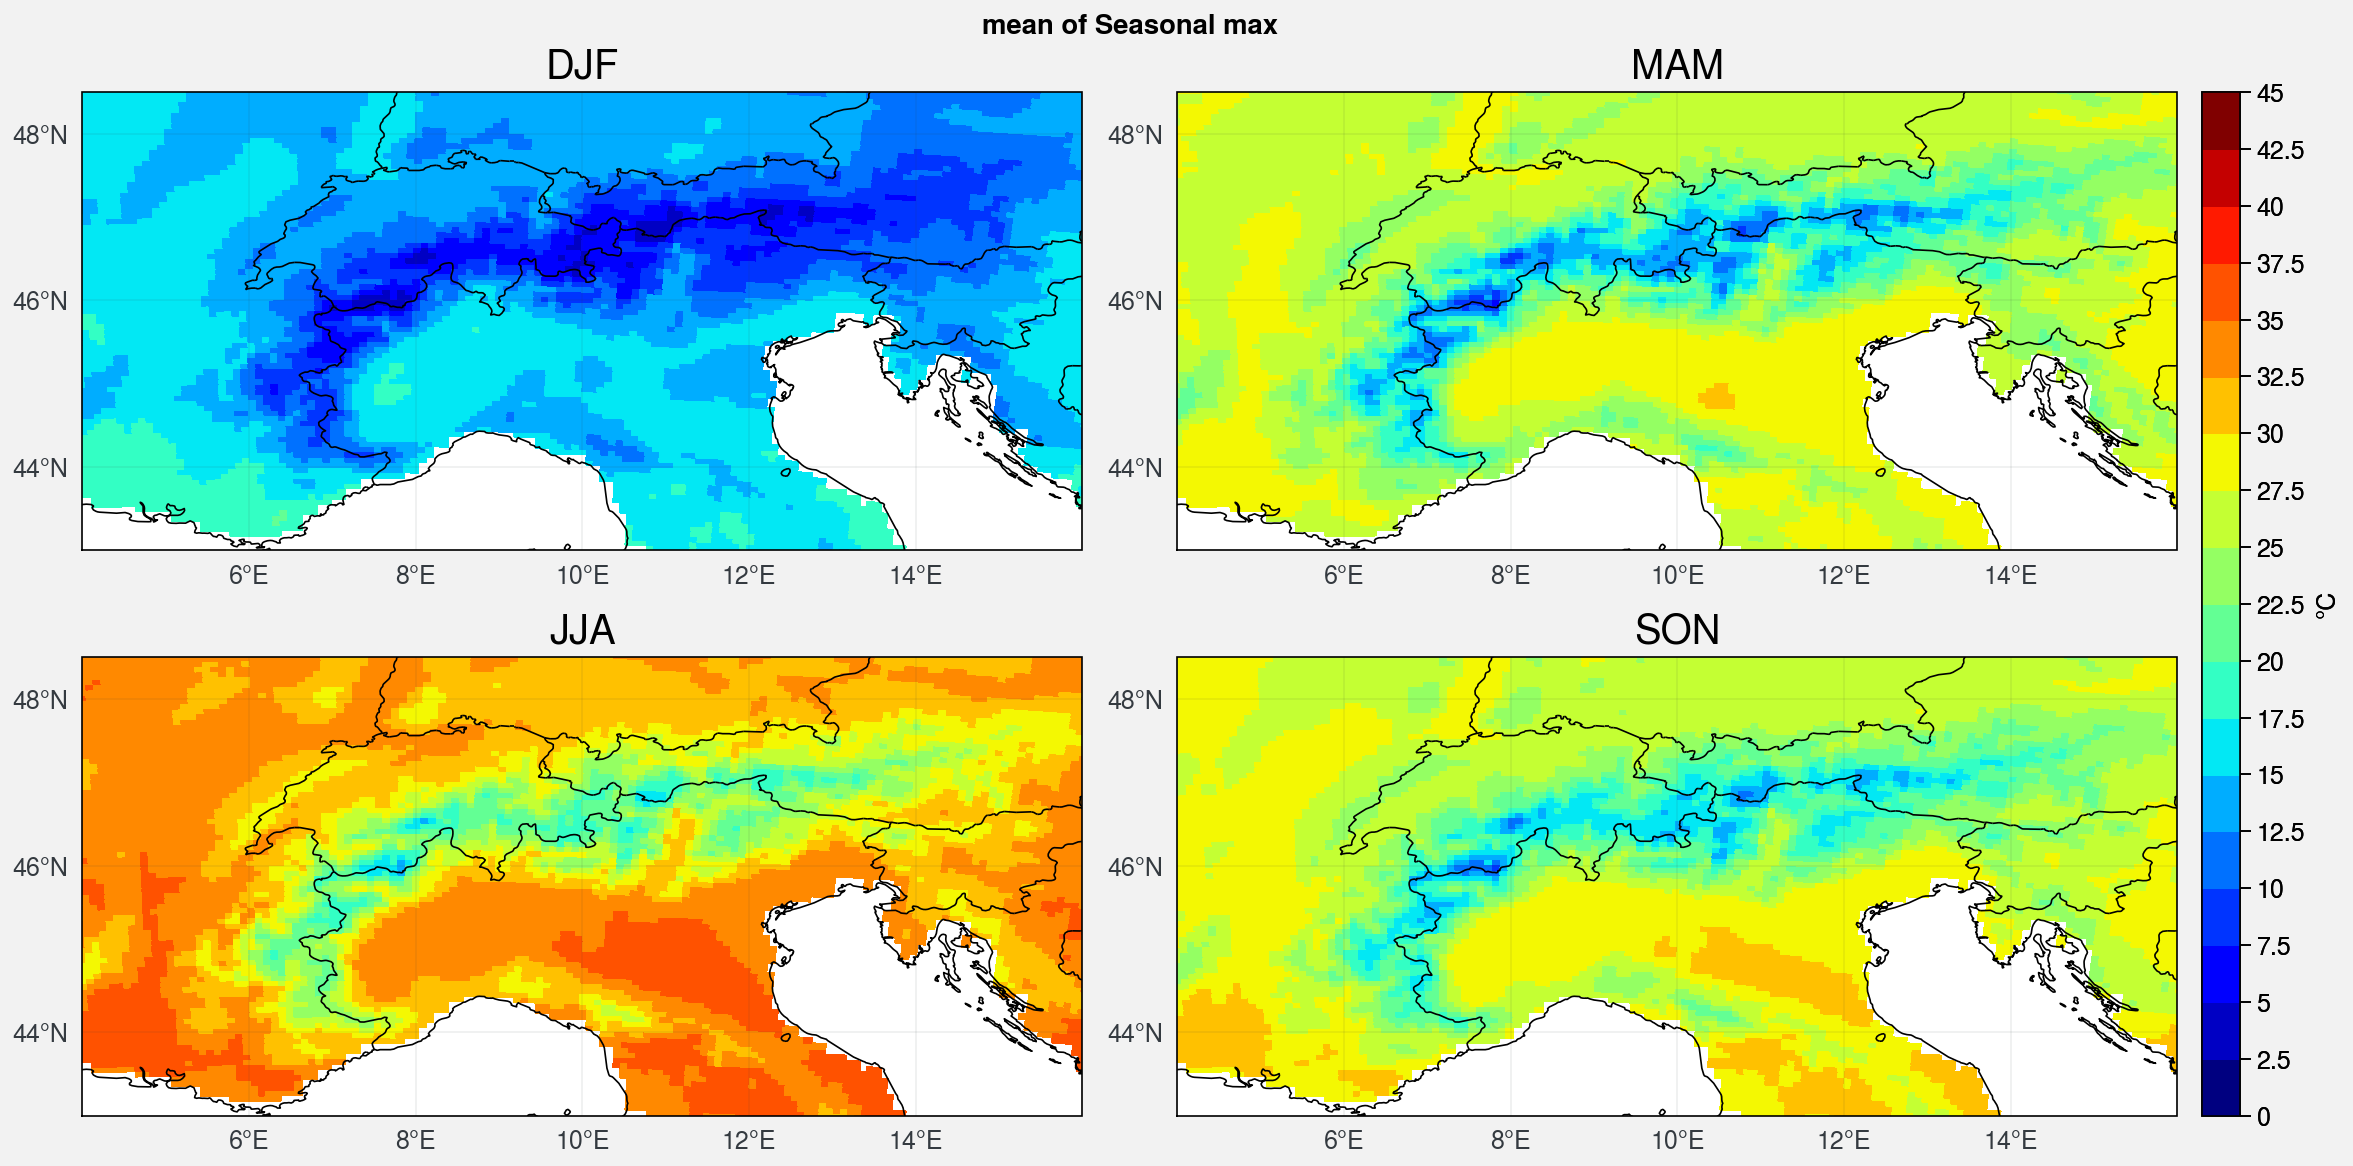

In [26]:
seasonal_max = np.mean(les_season_max,axis=0)
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds_out.lon, ds_out.lat,seasonal_max[i,:,:],levels=np.linspace(0,45,19),cmap='jet')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**normal_format,suptitle="mean of Seasonal max")
